In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [3]:
# Load in the data
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)

x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)


In [4]:
# the data is only 2D!
# convolution expects height x width x color
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)

(60000, 28, 28, 1)


In [5]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [6]:
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

In [7]:
# Compile and fit
# Note: make sure you are using the GPU for this!
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 12s 205us/sample - loss: 0.5306 - accuracy: 0.8042 - val_loss: 0.3994 - val_accuracy: 0.8530
Epoch 2/15
60000/60000 [==============================] - 11s 188us/sample - loss: 0.3599 - accuracy: 0.8655 - val_loss: 0.3423 - val_accuracy: 0.8784
Epoch 3/15
60000/60000 [==============================] - 11s 177us/sample - loss: 0.3142 - accuracy: 0.8819 - val_loss: 0.3337 - val_accuracy: 0.8801
Epoch 4/15
60000/60000 [==============================] - 12s 193us/sample - loss: 0.2811 - accuracy: 0.8944 - val_loss: 0.3071 - val_accuracy: 0.8870
Epoch 5/15
60000/60000 [==============================] - 12s 194us/sample - loss: 0.2522 - accuracy: 0.9041 - val_loss: 0.2990 - val_accuracy: 0.8871
Epoch 6/15
60000/60000 [==============================] - 11s 178us/sample - loss: 0.2326 - accuracy: 0.9114 - val_loss: 0.2907 - val_accuracy: 0.8949
Epoch 7/15
60000/60000 [====================

In [8]:
# Save the model to a temporary directory
import tempfile

MODEL_DIR = "model" #tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = model/1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/1/assets

Saved model:
total 168
drwxr-xr-x 2 rmedal rmedal   4096 Mar  5 07:26 assets
-rw-r--r-- 1 rmedal rmedal 162070 Mar  5 07:26 saved_model.pb
drwxr-xr-x 2 rmedal rmedal   4096 Mar  5 07:26 variables


In [9]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [22]:
#!pip install tensorflow-serving-api==2.0.0

In [51]:
! pip install tensorflow-serving-api

! echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list

! curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -
    
! sudo apt-get update && sudo apt-get install tensorflow-model-server    

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  61312      0 --:--:-- --:--:-- --:--:-- 62617
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:2 http://us.archive.ubuntu.com/ubuntu cosmic InRelease                     
Ign:3 http://us.archive.ubuntu.com/ubuntu cosmic-updates InRelease             
Ign:4 http://dl.google.com/linux/chrome/deb stable InRelease                   
Ign:5 http://us.archive.ubuntu.com/ubuntu cosmic-security InRelease            
Ign:6 http://us.archive.ubuntu.com/ubuntu cosmic-backports InRelease           
Hit:7 http://download.virtualbox.org/virtualbox/debian cosmic InRelease        
Err:8 http://us.archive.ubuntu.com/ubuntu cosmic Release   

Err:9 http://us.archive.ubuntu.com/ubuntu cosmic-updates Release               
  404  Not Found [IP: 91.189.91.14 80]
Hit:10 https://download.docker.com/linux/ubuntu bionic InRelease               
Err:11 http://us.archive.ubuntu.com/ubuntu cosmic-security Release             
  404  Not Found [IP: 91.189.91.14 80]
Hit:12 https://packages.microsoft.com/repos/vscode stable InRelease            
Get:13 https://dl.yarnpkg.com/debian stable InRelease [17.1 kB]                
Err:14 http://us.archive.ubuntu.com/ubuntu cosmic-backports Release            
  404  Not Found [IP: 91.189.91.14 80]
Get:15 https://download.docker.com/linux/ubuntu cosmic InRelease [45.3 kB]     
Ign:16 http://apt.pop-os.org/proprietary cosmic InRelease                      
Hit:17 http://dl.google.com/linux/chrome/deb stable Release                    
Ign:18 http://ppa.launchpad.net/maarten-baert/simplescreenrecorder/ubuntu cosmic InRelease
Get:19 http://storage.googleapis.com/tensorflow-serving-apt stable/tenso

In [52]:
#! sudo apt-get update 
#! sudo apt-get upgrade tensorflow-model-server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
sudo curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0E: This command can only be used by root.
100  2943  100  2943    0     0  11678      0 --:--:-- --:--:-- --:--:-- 11678
(23) Failed writing body
Reading package lists... Done
N: Ignoring file 'tensorflow-serving.listcurl' in directory '/etc/apt/sources.list.d/' as it has an invalid filename extension
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Target Packages (main/binary-amd64/Packages) is configured multiple times in /etc/apt/sources.list:15 and /etc/apt/sources.list.d/vscode.list:3
W: Target Packages (main/binary-all/Packages) is configured m

In [53]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [54]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [55]:
!tail server.log


nohup: failed to run command 'tensorflow_model_server': No such file or directory


In [44]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

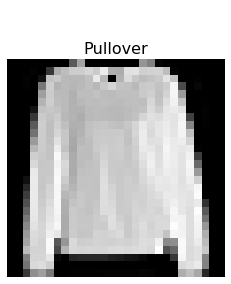

In [45]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

i = np.random.randint(0, len(x_test))
show(i, labels[y_test[i]])

In [46]:
# Format some data to pass to the server
# {
#   "signature_name": "serving_default",
#   "instances": [ an N x H x W x C list ],
# }

import json
data = json.dumps({"signature_name": "serving_default", "instances": x_test[0:3].tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

In [47]:
headers = {"content-type": "application/json"}
r = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
j = r.json()
print(j.keys())
print(j)

ConnectionError: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/fashion_model:predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd92d505320>: Failed to establish a new connection: [Errno 111] Connection refused',))

In [ ]:
# It looks like a 2-D array, let's check its shape
pred = np.array(j['predictions'])
print(pred.shape)

# This is the N x K output array from the model
# pred[n,k] is the probability that we believe the nth sample belongs to the kth class

In [ ]:
# Get the predicted classes
pred = pred.argmax(axis=1)

In [ ]:
# Map them back to strings
pred = [labels[i] for i in pred]
print(pred)

In [ ]:
# Get the true labels
actual = [labels[i] for i in y_test[:3]]
print(actual)

In [ ]:
for i in range(0,3):
  show(i, f"True: {actual[i]}, Predicted: {pred[i]}")